In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

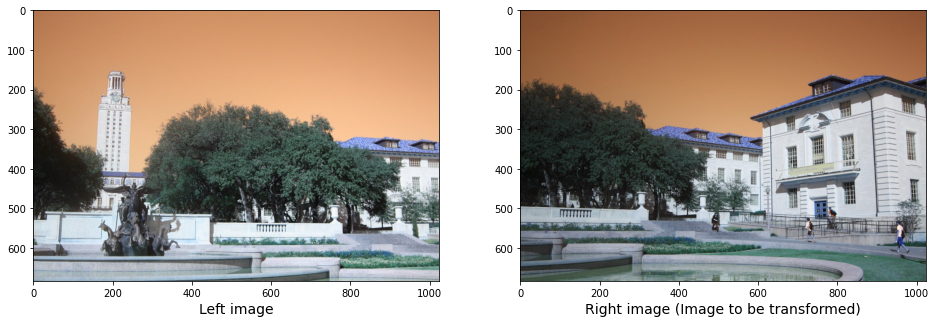

In [4]:
right_img = cv2.imread('foto1A.jpg')
left_img = cv2.imread('foto1B.jpg')

right_img_grayscale = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
left_img_grayscale = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(left_img, cmap="gray")
ax1.set_xlabel("Left image", fontsize=14)

ax2.imshow(right_img, cmap="gray")
ax2.set_xlabel("Right image (Image to be transformed)", fontsize=14)


plt.show()
# Displaying both the images


In [5]:
def select_descriptor_methods(image, method=None):    
    
    assert method is not None, "Please define a feature descriptor method. accepted Values are: 'sift'"
    
    if method == 'sift':
        descriptor = cv2.SIFT_create()
        
    (keypoints, features) = descriptor.detectAndCompute(image, None)
    
    return (keypoints, features)

In [6]:
feature_extraction_algo = 'sift'
feature_to_match = 'bf'

keypoints_train_img, features_train_img = select_descriptor_methods(right_img_grayscale, method=feature_extraction_algo)
keypoints_query_img, features_query_img = select_descriptor_methods(left_img_grayscale, method=feature_extraction_algo)

In [7]:
for keypoint in keypoints_query_img:
    x,y = keypoint.pt
    size = keypoint.size 
    orientation = keypoint.angle
    response = keypoint.response 
    octave = keypoint.octave
    class_id = keypoint.class_id


print (x,y)
 
print(size)

print(orientation)

print(response)
print(octave)
print(class_id)

1021.0968017578125 384.35296630859375
1.8598644733428955
131.4441680908203
0.026035811752080917
2556415
-1


In [8]:
print(len(keypoints_query_img))

features_query_img.shape

5355


(5355, 128)

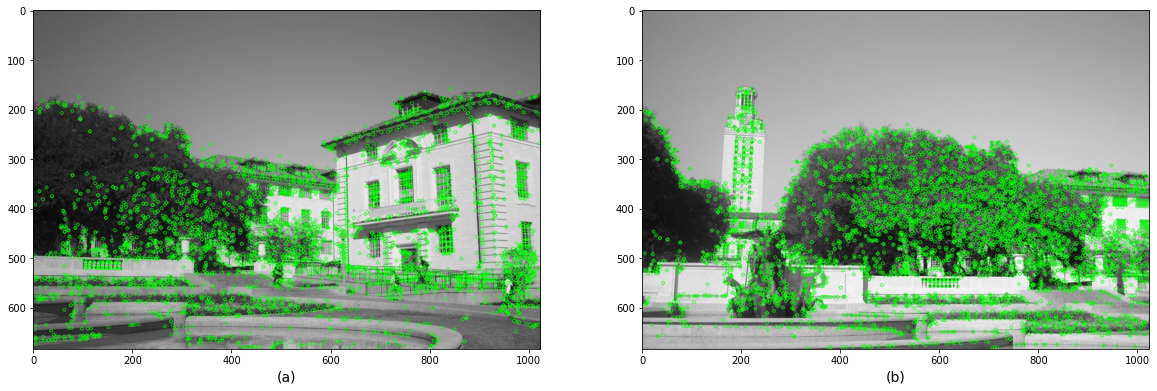

In [9]:
# Showing the edges and the key pixels in the images
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)

ax1.imshow(cv2.drawKeypoints(right_img_grayscale, keypoints_train_img, None, color=(0,255,0)))

ax1.set_xlabel("(a)", fontsize=14)

ax2.imshow(cv2.drawKeypoints(left_img_grayscale,keypoints_query_img,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [10]:
def create_matching_object(method,crossCheck):
    "Create and return a Matcher Object"
    
    # For Brute force matching, First we have to apply the cv2.BFMatcher() to both of the images  present
    # The function takes 2 parameters cv2.BFMatcher(normType, crossCheck)
    # normType - It defines the type of distance measurement
    # crossCheck -  Flase by default 
                #-  If it is true, Matcher returns only those matches 
    # with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match 
    # and vice-versa. 
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [11]:
def key_points_matching(features_train_img, features_query_img, method):
    bf = create_matching_object(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(features_train_img,features_query_img)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches with Brute force):", len(rawMatches))
    return rawMatches

Drawing: bf matched features Lines
Raw matches with Brute force): 1837


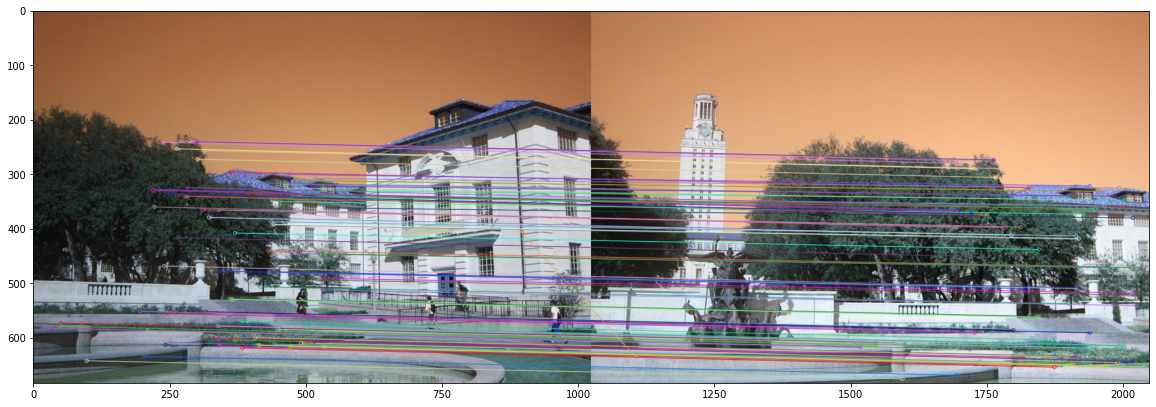

In [12]:
print("Drawing: {} matched features Lines".format(feature_to_match))

fig = plt.figure(figsize=(20,8))

if feature_to_match == 'bf':
    matches = key_points_matching(features_train_img, features_query_img, method=feature_extraction_algo)
    
    mapped_features_image = cv2.drawMatches(right_img,keypoints_train_img,left_img,keypoints_query_img,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(mapped_features_image)

In [13]:
def homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh):
    """ converting the keypoints to numpy arrays before passing them for calculating Homography Matrix.
    
    Because we are supposed to pass 2 arrays of coordinates to cv2.findHomography, as in I have these points in image-1, and I have points in image-2, so now what is the homography matrix to transform the points from image 1 to image 2
    """
    keypoints_train_img = np.float32([keypoint.pt for keypoint in keypoints_train_img])
    keypoints_query_img = np.float32([keypoint.pt for keypoint in keypoints_query_img])
    
    ''' For findHomography() - I need to have an assumption of a minimum of correspondence points that are present between the 2 images. Here, I am assuming that Minimum Match Count to be 4 '''
    if len(matches) > 4:
        # construct the two sets of points
        points_train = np.float32([keypoints_train_img[m.queryIdx] for m in matches])
        points_query = np.float32([keypoints_query_img[m.trainIdx] for m in matches])
        
        # Calculate the homography between the sets of points
        (H, status) = cv2.findHomography(points_train, points_query, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [14]:
M = homography_stitching(keypoints_train_img, keypoints_query_img, matches, reprojThresh=4)

if M is None:
    print("Error!")

(matches, Homography_Matrix, status) = M

print(Homography_Matrix)

[[ 7.68328088e-01  4.18018732e-02  4.45096282e+02]
 [-1.34917442e-01  9.16497735e-01  7.47623401e+01]
 [-2.10704500e-04 -2.83220790e-05  1.00000000e+00]]


width  2048


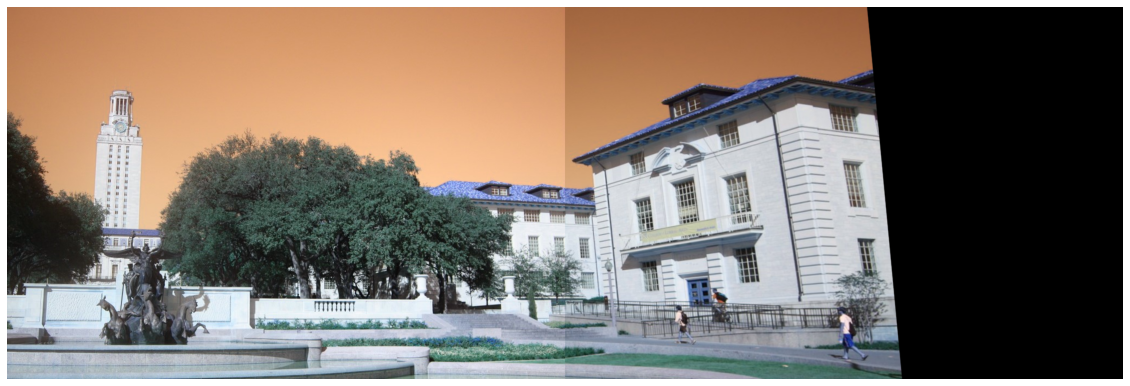

In [15]:
# Finding the width and the height of the combined processed image 
# For width we are just going to add the widht of the two individual images 
# And for height we are going to consider the maximum height out of both the images

width = left_img.shape[1] + right_img.shape[1]
print("width ", width) 

height = max(left_img.shape[0], right_img.shape[0])

# otherwise, apply a perspective warp to stitch the images together

# Now just plug that "Homography_Matrix"  into cv::warpedPerspective and I shall have a warped image1 into image2 frame

result = cv2.warpPerspective(right_img, Homography_Matrix,  (width, height))

# The warpPerspective() function returns an image or video whose size is the same as the size of the original image or video. Hence set the pixels as per my left_img

result[0:left_img.shape[0], 0:left_img.shape[1]] = left_img

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(result)


plt.show()